## Завдання №1-2

In [74]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

from matplotlib.widgets import Button, Slider, CheckButtons
from scipy import signal

print("Setup Complete")

Setup Complete


In [75]:
# Define initial parameters
init_amplitude = 5
init_frequency = 3
init_noise_amplitude = .0
init_noise_covariance = .2

In [76]:
# Harmmonic math func
def harmonic(x: np.array, amplitude: float, frequency: float, phase = .0): 
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

In [77]:
x = np.linspace(0, 1, 1000)

init_harmonic_save = harmonic(x, init_amplitude, init_frequency)

init_noise_save = np.random.normal(init_noise_amplitude, init_noise_covariance, len(x))


In [78]:
# Some things for save magic
class Parameters:
    def __init__(self, init_amplitude, init_frequency, init_harmonic, 
                 init_noise_amplitude, init_noise_covariance, init_noise_save):
        
        self.amplitude = init_amplitude
        self.frequency = init_frequency
        self.harmonic_save = init_harmonic_save
        self.noise_mean = init_noise_amplitude
        self.noise_covariance = init_noise_covariance
        self.noise_save = init_noise_save

params = Parameters(init_amplitude, init_frequency, init_harmonic_save, 
                    init_noise_amplitude, init_noise_covariance, init_noise_save)


In [79]:
# General func
def harmonic_with_noise(x: np.array, amplitude: float, frequency: float, 
                        phase = .0, noise_mean = .0, noise_covariance = .2, 
                        show_noise = False):
    
    harmonic_data = harmonic(x, amplitude, frequency)
    
    if (harmonic_data != params.harmonic_save).all():
        params.harmonic_save = harmonic_data

    noise_data = np.random.normal(noise_mean, noise_covariance, len(x))
    
    if (noise_mean != params.noise_mean) or (noise_covariance != params.noise_covariance):
        params.noise_mean = noise_mean
        params.noise_covariance = noise_covariance
        params.noise_save = noise_data
    else:
        noise_data = params.noise_save

    if show_noise:
        return harmonic_data + noise_data
    else: 
        return harmonic_data


In [80]:
def noise_filter(noise: np.ndarray, b_=3, a_=0.05):
    b, a = signal.butter(b_, a_)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, noise, zi=zi*noise[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, noise)
    return [z, z2, y]

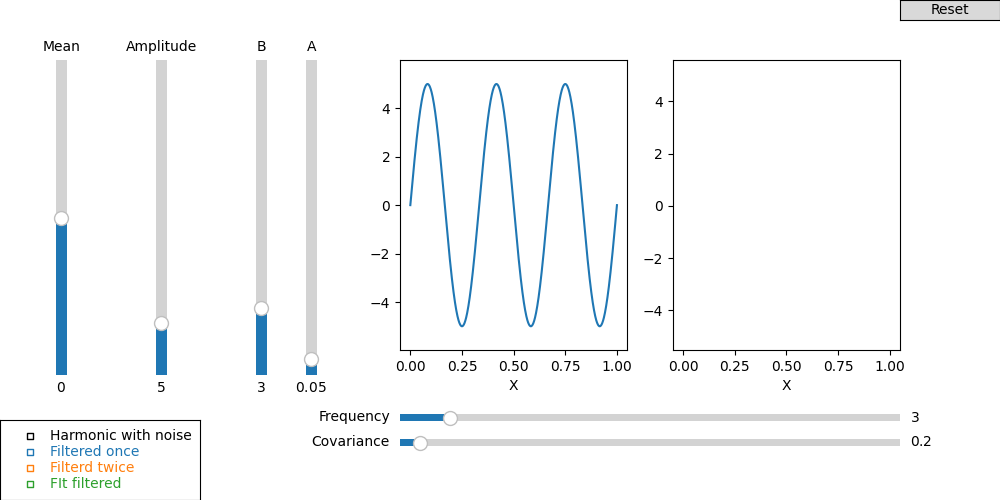

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# Harmonic line with noise
harmonic_line_with_noise, = axs[0].plot(x, harmonic_with_noise(x, init_amplitude, init_frequency, .0, show_noise=True ), 
                                    visible=False, label='Harmonic with noise', color='black')

# Hsrmonic line without noise
harmonic_line, = axs[0].plot(x, harmonic_with_noise(x, init_amplitude, init_frequency), label='Harmonic')

noise_y = harmonic_line_with_noise.get_ydata()
# Harmonic filtered line (1 time)
filtered_line_1, = axs[1].plot(x, noise_filter(noise_y)[0], visible=False, label='Filtered once')
# Harmonic filtered line (2 times)
filtered_line_2, = axs[1].plot(x, noise_filter(noise_y)[1], visible=False, label='Filterd twice')
# Harmonic filtered line (fit)
filtered_line_fit, = axs[1].plot(x, noise_filter(noise_y)[2], visible=False, label='FIt filtered')

axs[0].set_xlabel('X')
axs[1].set_xlabel('X')

fig.subplots_adjust(left=0.4, bottom=0.3)

# Horizontal sliders
# Slider for frequency
axfreq = fig.add_axes([0.4, 0.15, 0.5, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency',
    valmin=0,
    valmax=30,
    valinit=init_frequency,
)

# Slider for covariance
axcov = fig.add_axes([0.4, 0.1, 0.5, 0.03])
cov_slider = Slider(
    ax=axcov,
    label='Covariance',
    valmin=0,
    valmax=5,
    valinit=init_noise_covariance,
)


# Vertical sliders
# Slider for anplitude
axamp = fig.add_axes([0.15, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=30,
    valinit=init_amplitude,
    orientation="vertical"
)

# Slider for noise_mean
axmean = fig.add_axes([0.05, 0.25, 0.0225, 0.63])
mean_slider = Slider(
    ax=axmean,
    label="Mean",
    valmin=-1,
    valmax=1,
    valinit=init_noise_amplitude,
    orientation="vertical"
)

axb = fig.add_axes([0.25, 0.25, 0.0225, 0.63])
b_slider = Slider(
    ax=axb,
    label="B",
    valmin=0,
    valmax=14,
    valinit=3,
    valstep=1,
    orientation="vertical"
)

axa = fig.add_axes([0.3, 0.25, 0.0225, 0.63])
a_slider = Slider(
    ax=axa,
    label="A",
    valmin=0,
    valmax=.99,
    valinit=.05,
    orientation="vertical"
)


lines_by_label = {l.get_label(): l for l in [harmonic_line_with_noise, 
                                             filtered_line_1, 
                                             filtered_line_2, 
                                             filtered_line_fit]}

line_colors = [l.get_color() for l in lines_by_label.values()]

# CheckBox button for show_niose flag
noiseax = fig.add_axes([0, 0, 0.2, 0.16])
noise_mode_button = CheckButtons(
    ax=noiseax, 
    labels=lines_by_label.keys(),
    actives=[l.get_visible() for l in lines_by_label.values()],
    label_props={'color': line_colors},
    frame_props={'edgecolor': line_colors},
    check_props={'facecolor': line_colors},
)

# Reset button
resetax = fig.add_axes([0.9, 0.96, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    freq_slider.reset()
    amp_slider.reset()
    mean_slider.reset()
    cov_slider.reset()
    b_slider.reset()
    a_slider.reset()
    fig.canvas.draw_idle()
    
button.on_clicked(reset)

# Func for updates
def update(val):
    harmonic_line.set_ydata(harmonic(x, amp_slider.val, freq_slider.val, .0))
    
    noise_y = harmonic_with_noise(x, amp_slider.val, freq_slider.val, .0, 
                                  mean_slider.val, cov_slider.val, True)
    harmonic_line_with_noise.set_ydata(noise_y)
    filtered_line_1.set_ydata(noise_filter(noise_y, b_slider.val, a_slider.val)[0])
    filtered_line_2.set_ydata(noise_filter(noise_y, b_slider.val, a_slider.val)[1])
    filtered_line_fit.set_ydata(noise_filter(noise_y, b_slider.val, a_slider.val)[2])
    fig.canvas.draw_idle()


def update_line(line):
    ln = lines_by_label[line]
    ln.set_visible(not ln.get_visible())
    ln.figure.canvas.draw_idle()

# register the update function
noise_mode_button.on_clicked(update_line)
freq_slider.on_changed(update)
amp_slider.on_changed(update)
cov_slider.on_changed(update)
mean_slider.on_changed(update)
b_slider.on_changed(update)
a_slider.on_changed(update)

# Show some palka
plt.show()

## Завдання №3

In [65]:
import plotly.graph_objects as go
from ipywidgets import interact, widgets, Layout

show_in_time = True

print("Setup Complete")

Setup Complete


In [66]:
amplitude = widgets.FloatSlider(
    value=init_amplitude,
    min=.0,
    max=30.0,
    step=.01,
    description='Amplitude',
    orientation='vertical',
    continuous_update=show_in_time,
    layout=Layout( height='auto') 
    
)

mean = widgets.FloatSlider(
    value=init_noise_amplitude,
    min=-1.0,
    max=1.0,
    step=.01,
    description='Mean',
    orientation='vertical',
    continuous_update=show_in_time,
    layout=Layout( height='auto')
)

vertical_box_layout = Layout(display='flex', 
                             flex_flow='row', 
                             align_items='stretch', 
                             #border='solid',
                             width='20%')

vertical_box = widgets.Box(children=[amplitude, mean], layout=vertical_box_layout)


In [67]:
frequency = widgets.FloatSlider(
    value=init_frequency,
    min=.0,
    max=30.0,
    step=.01,
    description='Frequency',
    continuous_update=show_in_time,
    layout=Layout( width='auto')
)

covariance = widgets.FloatSlider(
    value=init_noise_covariance,
    min=.0,
    max=5.0,
    step=.01,
    description='Covariance',
    continuous_update=show_in_time,
    layout=Layout( width='auto')
)

horizontal_box_layout = Layout(display='flex', 
                               flex_flow='column', 
                               align_items='stretch', 
                               #border='solid', 
                               width='auto')

horizontal_box = widgets.Box(children=[frequency, covariance], layout=horizontal_box_layout)


In [68]:
show_harmonic = widgets.Checkbox(
    value=True,
    description='Harmonic',
    disabled=False,
    indent=False
)

show_harmonic_with_noise = widgets.Checkbox(
    value=False,
    description='Harmonic with noise',
    disabled=False,
    indent=False
)

show_filtered_line = widgets.Checkbox(
    value=False,
    description='Filtered line',
    disabled=False,
    indent=False
)

checkbox_box_layout = Layout(display='flex', 
                             flex_flow='column', 
                             align_items='center',
                             #border='solid', 
                             width='auto')

checkbox_box = widgets.Box(children=[show_harmonic, show_harmonic_with_noise, show_filtered_line], layout=checkbox_box_layout)

In [69]:
reset = widgets.Button( 
    description='Reset',
    disabled=False,
    button_style='',
    tooltip='Click me'
)
def reset_own(a):
    amplitude.value=init_amplitude
    mean.value=init_noise_amplitude
    frequency.value=init_frequency
    covariance.value=init_noise_covariance

reset.on_click(reset_own)

reset_layout = Layout(display='flex', 
                      flex_flow='column', 
                      align_items='center',
                      #border='solid', 
                      width='auto')
reset_box = widgets.Box(children=[reset], layout=reset_layout)


In [70]:
def chebyshev_transfer_function(epsilon, N, omega):
    H = 1 / np.sqrt(1 + epsilon**2 * (np.cos(N * np.arccos(omega)))**2)
    return H

def my_fftfreq(n, d=1.0):
    fftfreq1 = np.arange(n // 2, dtype=float) / (n * d)
    fftfreq2 = (np.arange(n // 2, n, dtype=float) - n) / (n * d)
    return np.concatenate((fftfreq1, fftfreq2))


def my_dft(x):
    N = len(x)
    X = np.zeros(N, dtype=np.complex_)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X


def my_idft(X):
    N = len(X)
    x = np.zeros(N, dtype=np.complex_)
    for n in range(N):
        for k in range(N):
            x[n] += X[k] * np.exp(2j * np.pi * k * n / N)
    return x / N


def apply_chebyshev_filter(signal, epsilon=.5, N=2):
    omega = my_fftfreq(len(signal))
    H = chebyshev_transfer_function(epsilon, N, omega)
    filtered_signal = my_idft(my_dft(signal) * H).real
    return filtered_signal


In [71]:
fig = go.FigureWidget()
#fig.show()


# Harmonic with noise
harmonic_noisef = fig.add_scatter(name='Harmonic with noise', line=dict(color='blue'))
line_harmonic_with_noise = harmonic_noisef.data[0]

# Harmonic
harmonicf = fig.add_scatter(name='Harmonic', line=dict(color='red'))
line_harmonic = harmonicf.data[0]

# Filtered
filteredf = fig.add_scatter(name='Filtered', line=dict(color='green'))
line_filtered = filteredf.data[0]

fig.layout.xaxis.title = 'x'
fig.layout.yaxis.range = [-8, 8]

fig.update_layout(
    width=800, 
    height=400, 
)

print("Figure constructed")


Figure constructed


In [72]:
def response(change):
    # with fig.batch_update():
        
    fig.data[0].x=x
    fig.data[0].y=harmonic_with_noise(x, amplitude.value, frequency.value, .0, mean.value, covariance.value, True)
    
    fig.data[1].x=x
    fig.data[1].y=harmonic(x, amplitude.value, frequency.value, .0)

        
def show_response(e):
    fig.data[0].visible = show_harmonic_with_noise.value
    fig.data[1].visible = show_harmonic.value
    fig.data[2].visible = show_filtered_line.value
    if show_filtered_line.value:
        fig.data[2].x=x
        fig.data[2].y=apply_chebyshev_filter(harmonic(x, amplitude.value, frequency.value, .0))
        


amplitude.observe(response, names="value")
frequency.observe(response, names="value")
mean.observe(response, names="value")
covariance.observe(response, names="value")
show_harmonic.observe(show_response, names="value")
show_harmonic_with_noise.observe(show_response, names="value")
show_filtered_line.observe(show_response, names="value")

response("Some")
show_response("Somw")


In [73]:
widgets.HBox([vertical_box, 
              widgets.VBox([fig, 
                       horizontal_box, 
                       checkbox_box, 
                       reset_box])])